In [1]:
##librerias a importar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
import seaborn as sns
from datetime import datetime
from pandas_profiling import ProfileReport
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


C:\Users\anaso\AppData\Local\Temp\ipykernel_1480\2345657694.py:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## Serie de tiempo de importaciones

In [2]:
importaciones = pd.read_excel('importaciones.xlsx', sheet_name='IMPORTACION', index_col=None, skiprows=6, nrows=269, usecols='A:AB')
importaciones['Fecha'] = pd.to_datetime(importaciones['Fecha'])
importaciones['Año'] = pd.DatetimeIndex(importaciones['Fecha']).year
importaciones['Mes'] = pd.DatetimeIndex(importaciones['Fecha']).month
importaciones.set_index('Fecha', inplace=True)
importaciones = importaciones[['Mes', 'Año', 'Gasolina superior', 'Gasolina regular', 'Diesel bajo azufre', 'Gas licuado de petróleo']]
importaciones.rename(columns = {'Gasolina superior':'Super', 'Gasolina regular':'Regular', 'Diesel bajo azufre': 'Diesel', 'Gas licuado de petróleo':'Gas licuado'}, inplace = True)
importaciones

C:\Users\anaso\AppData\Local\Temp\ipykernel_1480\115605410.py:1: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  importaciones = pd.read_excel('importaciones.xlsx', sheet_name='IMPORTACION', index_col=None, skiprows=6, nrows=269, usecols='A:AB')


,Mes,Año,Super,Regular,Diesel,Gas licuado
Fecha,,,,,,
2001-01-01,1,2001,373963.96,177776.50,0.00,194065.738095
2001-02-01,2,2001,243091.07,123115.99,0.00,170703.380952
2001-03-01,3,2001,312084.38,161726.42,0.00,161837.371429
2001-04-01,4,2001,285054.89,127338.74,0.00,163048.642857
2001-05-01,5,2001,300913.67,168730.19,0.00,171518.861905
...,...,...,...,...,...,...
2023-01-01,1,2023,578792.14,909391.13,1442099.08,497780.690000
2023-02-01,2,2023,685183.06,725101.20,1267967.39,652984.710000
2023-03-01,3,2023,633849.05,803262.67,1317519.91,711978.350000


#### Analisis exploratorio

In [3]:
##Para un analisis exploratorio más completo
profile1 = ProfileReport(importaciones)
#profile1.to_file("AnalisisExploratorioImportaciones.html")

#### Serie de tiempo del diesel

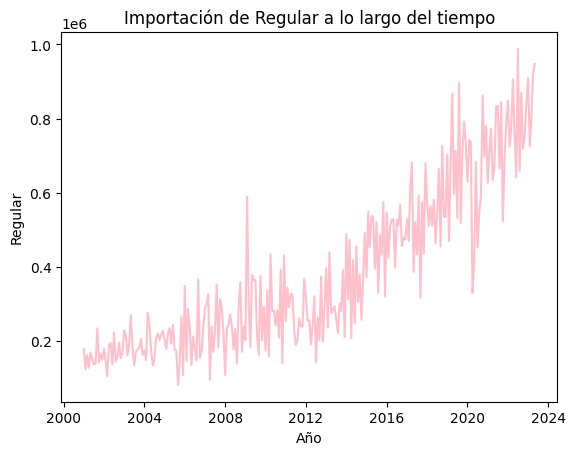

In [4]:
plt.plot(importaciones['Regular'], color = 'pink')
plt.gca().set(title="Importación de Regular a lo largo del tiempo", xlabel="Año", ylabel="Regular")
plt.show()

Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media

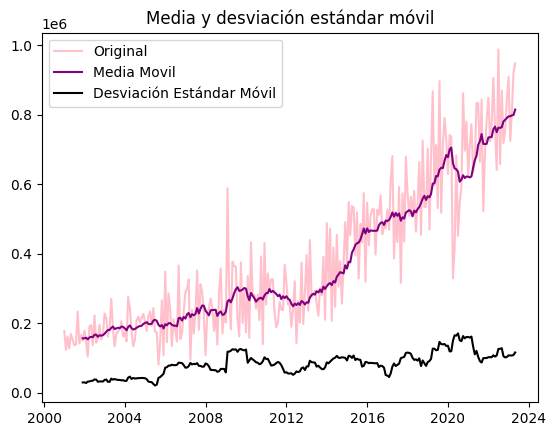

In [5]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = importaciones['Regular'].rolling(window=12).mean()
deMovil = importaciones['Regular'].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(importaciones['Regular'], color="pink", label="Original")
media = plt.plot(mediaMovil, color='purple', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

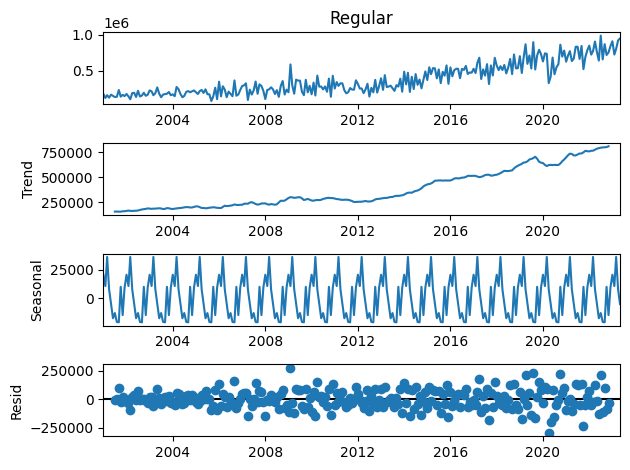

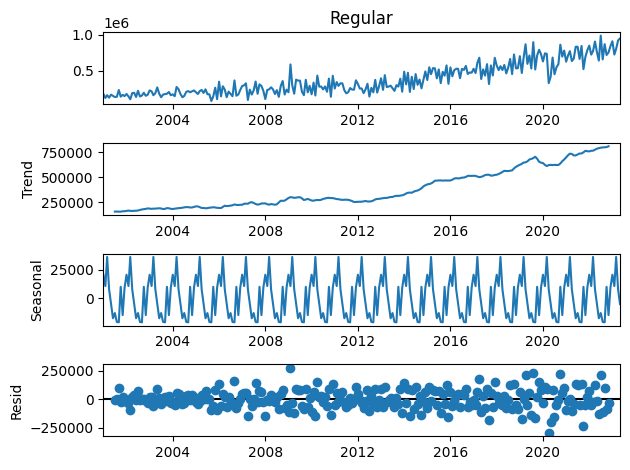

In [6]:
descomposicion = seasonal_decompose(importaciones['Regular'])
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [7]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(importaciones['Regular'], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          1.090748
p-value                        0.995137
# de retardos usados           9.000000
# de observaciones usadas    259.000000
Critical Value (1%)           -3.455853
Critical Value (5%)           -2.872765
Critical Value (10%)          -2.572752
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [8]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
imporegular = importaciones['Regular'].diff()
imporegular.fillna(0,inplace=True)
dfTest = adfuller(imporegular)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -9.869796e+00
p-value                      4.023147e-17
# de retardos usados         8.000000e+00
# de observaciones usadas    2.600000e+02
Critical Value (1%)         -3.455754e+00
Critical Value (5%)         -2.872721e+00
Critical Value (10%)        -2.572728e+00
dtype: float64


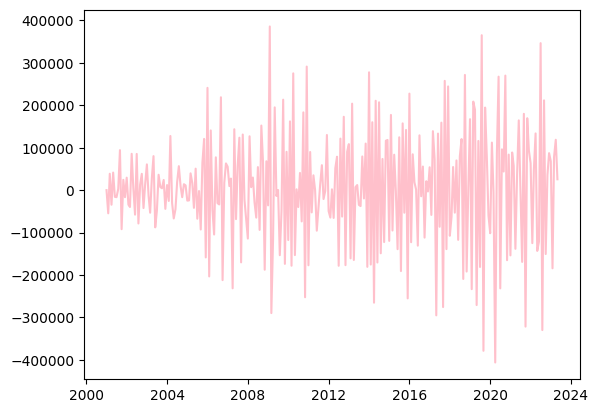

In [9]:
plt.plot(imporegular, color="pink")

In [10]:
# Convertir 'imporegular' en un array 2D utilizando reshape(-1, 1)
imporegular_2d = np.array(imporegular).reshape(-1, 1)

# Crear el objeto StandardScaler y normalizar los datos
scaler = StandardScaler()
imporegular_scaled = scaler.fit_transform(imporegular_2d)
imporegular_normalized = imporegular_scaled.flatten()

In [11]:
#Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

entrenamiento = round(0.6*len(imporegular_scaled))
val_prueba = round(0.2*len(imporegular_scaled))
test = imporegular_scaled[(entrenamiento+val_prueba)-1:]
validation = imporegular_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = imporegular_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))

Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [12]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)


#### Modelo de predicción

In [13]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

54

In [14]:
### Creamos el modelo.   
# Vamos a utilizar solo una capa lstm  
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1)                    12        
                                                                 
 dense (Dense)               (1, 1)                    2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [15]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [16]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
161/161 [==============================] - 3s 5ms/step - loss: 0.6799 - val_loss: 1.0573
Epoch 2/50
161/161 [==============================] - 0s 2ms/step - loss: 0.6621 - val_loss: 1.0311
Epoch 3/50
161/161 [==============================] - 0s 2ms/step - loss: 0.6441 - val_loss: 1.0039
Epoch 4/50
161/161 [==============================] - 0s 2ms/step - loss: 0.6260 - val_loss: 0.9759
Epoch 5/50
161/161 [==============================] - 0s 2ms/step - loss: 0.6078 - val_loss: 0.9468
Epoch 6/50
161/161 [==============================] - 0s 2ms/step - loss: 0.5895 - val_loss: 0.9168
Epoch 7/50
161/161 [==============================] - 0s 2ms/step - loss: 0.5714 - val_loss: 0.8860
Epoch 8/50
161/161 [==============================] - 0s 2ms/step - loss: 0.5535 - val_loss: 0.8546
Epoch 9/50
161/161 [==============================] - 0s 2ms/step - loss: 0.5362 - val_loss: 0.8232
Epoch 10/50
161/161 [==============================] - 0s 2ms/step - loss: 0.5197 - val_loss: 0.7922

Como vemos la pérdida empieza a disminuir bastante bien. Hay bastante diferencia entre el modelo de entrenamiento y el de validación.  

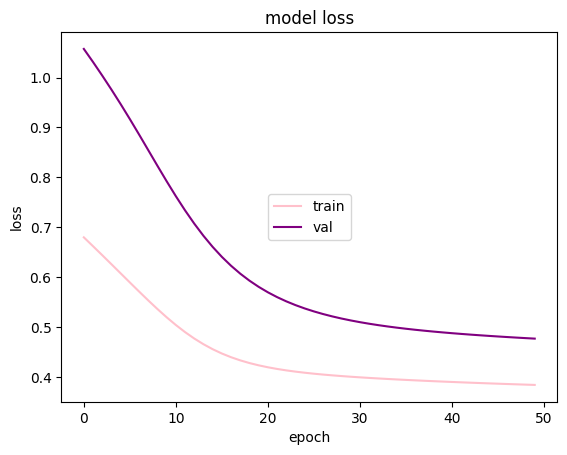

In [17]:
plt.plot(history.history['loss'], color = 'pink')
plt.plot(history.history['val_loss'], color = 'purple')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [18]:
# Evaluación en los datos de entrenamiento
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x=x_train,
    y=y_train,
    batch_size=lote,  # Especificar el tamaño del lote utilizado en el modelo
    verbose=1
)

# Evaluación en los datos de validación
print("Pérdida en Validación")
modelo1.evaluate(
    x=x_val,
    y=y_val,
    batch_size=lote,  # Especificar el tamaño del lote utilizado en el modelo
    verbose=1
)

# Evaluación en los datos de prueba
print("Pérdida en Prueba")
modelo1.evaluate(
    x=x_test,
    y=y_test,
    batch_size=lote,  # Especificar el tamaño del lote utilizado en el modelo
    verbose=1
)

Pérdida en Entrenamiento
161/161 [==============================] - 0s 2ms/step - loss: 0.3822
Pérdida en Validación
54/54 [==============================] - 0s 2ms/step - loss: 0.4770
Pérdida en Prueba
54/54 [==============================] - 0s 2ms/step - loss: 1.2188


1.2187910079956055

In [19]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = importaciones['Regular'].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = importaciones['Regular'].values , n=entrenamiento+val_prueba)

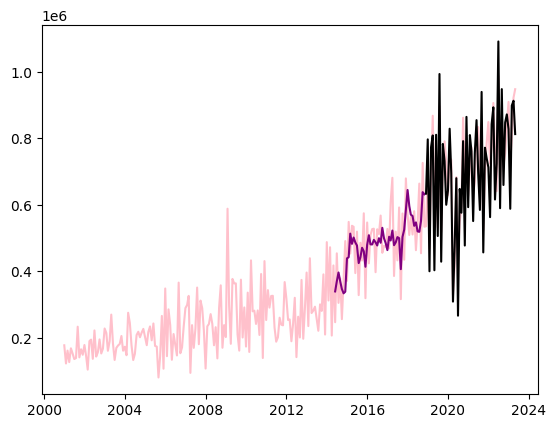

In [20]:
df_val = pd.DataFrame(prediccion_val,index=importaciones['Regular'][(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=importaciones['Regular'][entrenamiento+len(df_val):len(importaciones)].index)


plt.plot(importaciones['Regular'], color = 'pink')
plt.plot(df_val,color = 'purple' )
plt.plot(df_test, color = 'black')

## Serie de tiempo de consumo

In [55]:
consumos = pd.read_excel('consumos.xlsx', sheet_name='CONSUMO', index_col=None, skiprows=6, nrows=281, usecols='A:AB')
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'])
consumos['Año'] = pd.DatetimeIndex(consumos['Fecha']).year
consumos['Mes'] = pd.DatetimeIndex(consumos['Fecha']).month
consumos.set_index('Fecha', inplace=True)
consumos = consumos[['Mes','Año','Gasolina superior', 'Gasolina regular', 'Diesel bajo azufre', 'Gas licuado de petróleo']]
consumos.rename(columns = {'Gasolina superior':'Super', 'Gasolina regular':'Regular', 'Diesel bajo azufre': 'Diesel', 'Gas licuado de petróleo':'Gas licuado'}, inplace = True)
consumos

C:\Users\anaso\AppData\Local\Temp\ipykernel_1480\1185377401.py:1: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  consumos = pd.read_excel('consumos.xlsx', sheet_name='CONSUMO', index_col=None, skiprows=6, nrows=281, usecols='A:AB')


,Mes,Año,Super,Regular,Diesel,Gas licuado
Fecha,,,,,,
2000-01-01,1,2000,308156.82,202645.20,0.00,194410.476190
2000-02-01,2,2000,307766.31,205530.96,0.00,174710.552381
2000-03-01,3,2000,331910.29,229499.56,0.00,189234.066667
2000-04-01,4,2000,315648.08,210680.40,0.00,174330.607143
2000-05-01,5,2000,319667.97,208164.34,0.00,191745.147619
...,...,...,...,...,...,...
2023-01-01,1,2023,599501.29,804524.73,1285932.51,574148.000000
2023-02-01,2,2023,544144.00,737345.64,1226884.63,497273.190000
2023-03-01,3,2023,656941.64,875010.34,1463008.43,588892.160000


#### Analisis exploratorio

In [56]:
##Para un analisis exploratorio más completo
profile2 = ProfileReport(consumos)
#profile2.to_file("AnalisisExploratorioConsumos.html")

#### Serie de tiempo del Regular

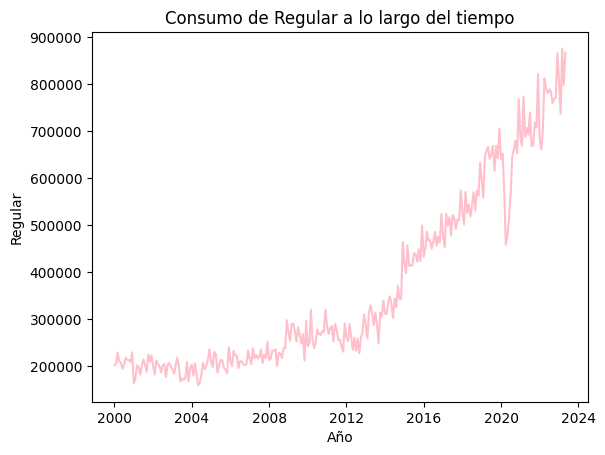

In [57]:
plt.plot(consumos['Regular'], color = 'pink')
plt.gca().set(title="Consumo de Regular a lo largo del tiempo", xlabel="Año", ylabel="Regular")
plt.show()

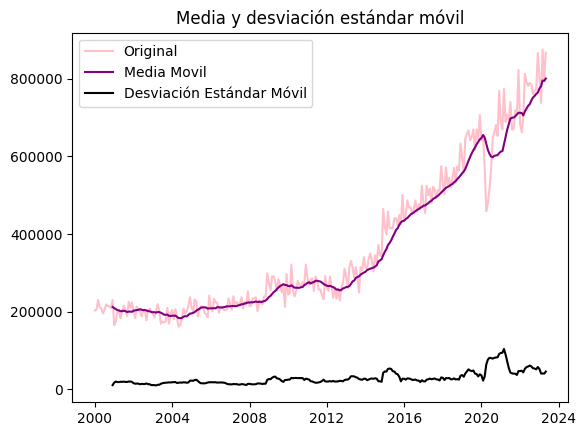

In [58]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = consumos['Regular'].rolling(window=12).mean()
deMovil = consumos['Regular'].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(consumos['Regular'], color="pink", label="Original")
media = plt.plot(mediaMovil, color='purple', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

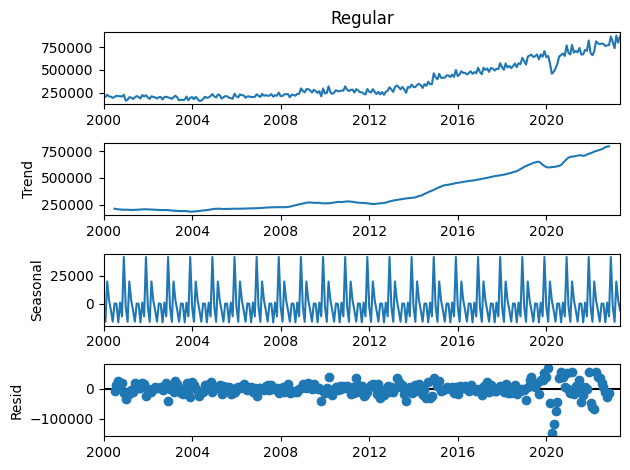

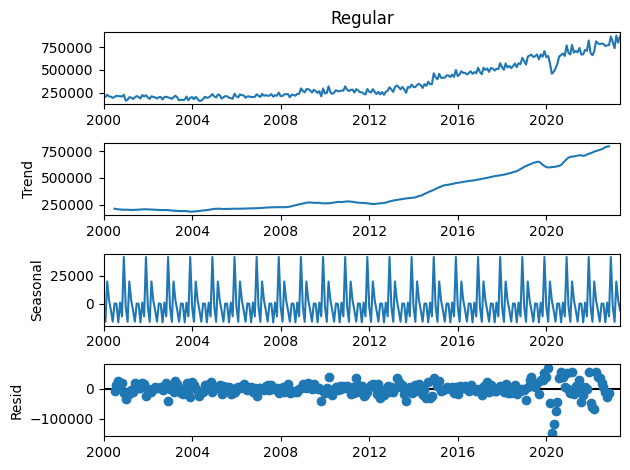

In [59]:
descomposicion = seasonal_decompose(consumos['Regular'])
descomposicion.plot()

In [60]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumos['Regular'], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          3.037520
p-value                        1.000000
# de retardos usados          14.000000
# de observaciones usadas    266.000000
Critical Value (1%)           -3.455175
Critical Value (5%)           -2.872468
Critical Value (10%)          -2.572593
dtype: float64


In [61]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
consuregular = consumos['Regular'].diff()
consuregular.fillna(0,inplace=True)
dfTest = adfuller(consuregular)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.079297
p-value                        0.001048
# de retardos usados          16.000000
# de observaciones usadas    264.000000
Critical Value (1%)           -3.455365
Critical Value (5%)           -2.872551
Critical Value (10%)          -2.572638
dtype: float64


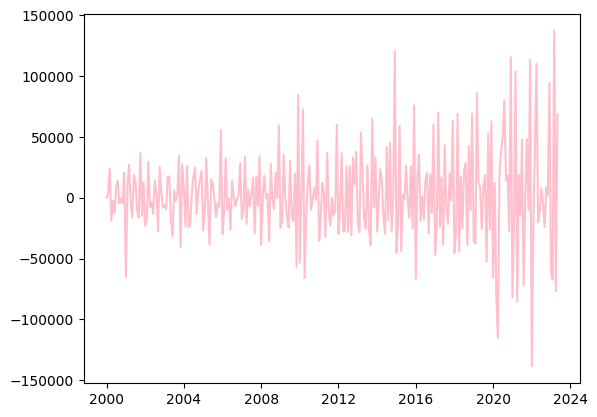

In [73]:
plt.plot(consuregular, color="pink")

In [74]:
# Convertir 'imporegular' en un array 2D utilizando reshape(-1, 1)
consuregular2d = np.array(consuregular).reshape(-1, 1)


scaler = StandardScaler()
consuregularscal = scaler.fit_transform(consuregular2d) 
consuregularscal[1:7]

array([[ 0.0138796 ],
       [ 0.57432324],
       [-0.56310076],
       [-0.1297166 ],
       [-0.41042011],
       [ 0.18885562]])

In [75]:
entrenamiento = round(0.6*len(consuregularscal))
val_prueba = round(0.2*len(consuregularscal))
test = consuregularscal[(entrenamiento+val_prueba)-1:]
validation = consuregularscal[(entrenamiento):entrenamiento+val_prueba+1]
train = consuregularscal[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

57

Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [76]:
from operator import concat

def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)


#### Modelo de predicción

In [77]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

In [78]:
### Creamos el modelo.   
# Vamos a utilizar solo una capa lstm  
modelo2 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo2.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo2.add(Dense(1))
modelo2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1)                    12        
                                                                 
 dense_4 (Dense)             (1, 1)                    2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [79]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [80]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
) 

Epoch 1/50


169/169 [==============================] - 4s 8ms/step - loss: 0.5167 - val_loss: 1.1234
Epoch 2/50
169/169 [==============================] - 1s 4ms/step - loss: 0.5030 - val_loss: 1.0978
Epoch 3/50
169/169 [==============================] - 1s 4ms/step - loss: 0.4923 - val_loss: 1.0764
Epoch 4/50
169/169 [==============================] - 1s 4ms/step - loss: 0.4839 - val_loss: 1.0589
Epoch 5/50
169/169 [==============================] - 1s 4ms/step - loss: 0.4773 - val_loss: 1.0446
Epoch 6/50
169/169 [==============================] - 1s 4ms/step - loss: 0.4721 - val_loss: 1.0326
Epoch 7/50
169/169 [==============================] - 1s 4ms/step - loss: 0.4676 - val_loss: 1.0212
Epoch 8/50
169/169 [==============================] - 1s 3ms/step - loss: 0.4631 - val_loss: 1.0086
Epoch 9/50
169/169 [==============================] - 1s 3ms/step - loss: 0.4582 - val_loss: 0.9944
Epoch 10/50
169/169 [==============================] - 0s 3ms/step - loss: 0.4528 - val_loss: 0.9788
Epoch 11/5

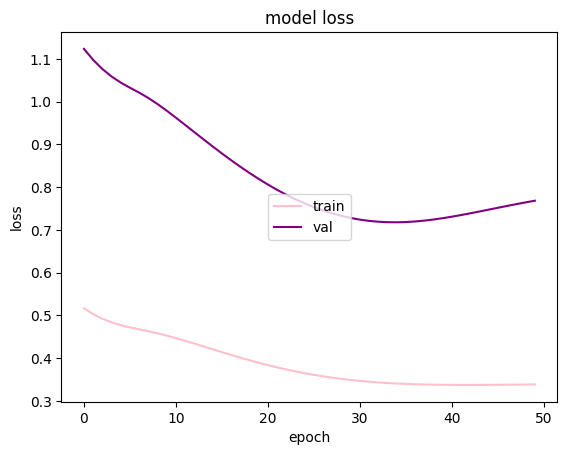

In [81]:
plt.plot(history.history['loss'], color = 'pink')
plt.plot(history.history['val_loss'], color = 'purple')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [82]:

# Evaluación en los datos de entrenamiento
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x=x_train,
    y=y_train,
    batch_size=lote,  # Especificar el tamaño del lote utilizado en el modelo
    verbose=1
)

# Evaluación en los datos de validación
print("Pérdida en Validación")
modelo2.evaluate(
    x=x_val,
    y=y_val,
    batch_size=lote,  # Especificar el tamaño del lote utilizado en el modelo
    verbose=1
)

# Evaluación en los datos de prueba
print("Pérdida en Prueba")
modelo2.evaluate(
    x=x_test,
    y=y_test,
    batch_size=lote,  # Especificar el tamaño del lote utilizado en el modelo
    verbose=1
)

Pérdida en Entrenamiento
169/169 [==============================] - 0s 1ms/step - loss: 0.3363
Pérdida en Validación
56/56 [==============================] - 0s 1ms/step - loss: 0.7679
Pérdida en Prueba
56/56 [==============================] - 0s 1ms/step - loss: 2.5964


2.596383810043335

In [83]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = consumos['Regular'].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = consumos['Regular'].values , n=entrenamiento+val_prueba)

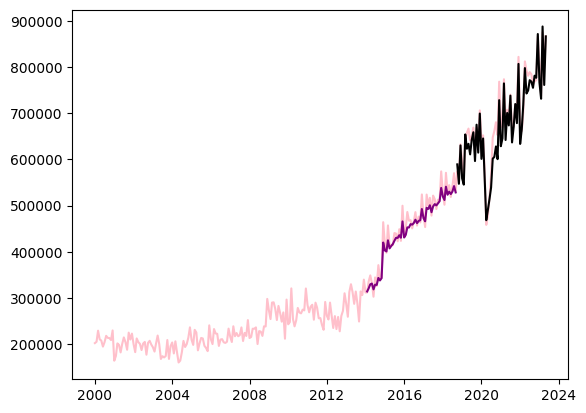

In [84]:
df_val = pd.DataFrame(prediccion_val,index=consumos['Regular'][(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=consumos['Regular'][entrenamiento+len(df_val):len(consumos)].index)


plt.plot(consumos['Regular'], color = 'pink')
plt.plot(df_val,color = 'purple' )
plt.plot(df_test, color = 'black')

## Serie de tiempo de precios

In [156]:
# Leer el archivo Excel y convertir la columna de fechas al formato adecuado

precios = pd.read_excel('precios.xlsx', sheet_name='2022', index_col=None, skiprows=6, nrows=1000, usecols='A:F')

precios['Fecha'] = pd.to_datetime(precios['Fecha'])
precios['Año'] = pd.DatetimeIndex(precios['Fecha']).year
precios.set_index('Fecha', inplace=True)
precios = precios[['Mes','Año','Superior', 'Regular', 'Diesel']]

precios

,Mes,Año,Superior,Regular,Diesel
Fecha,,,,,
2021-01-01,1,2021,21.91,21.11,17.61
2021-01-02,1,2021,21.91,21.11,17.61
2021-01-03,1,2021,21.91,21.11,17.61
2021-01-04,1,2021,21.91,21.11,17.61
2021-01-05,1,2021,21.91,21.11,17.61
...,...,...,...,...,...
2023-08-02,8,2023,36.28,34.77,29.68
2023-08-03,8,2023,36.28,34.77,29.68
2023-08-04,8,2023,36.28,34.77,29.68


#### Analisis exploratorio

In [157]:
##Para un analisis exploratorio más completo
profile3 = ProfileReport(precios)
#profile3.to_file("AnalisisExploratorioPrecios.html")

#### Serie de tiempo del Regular


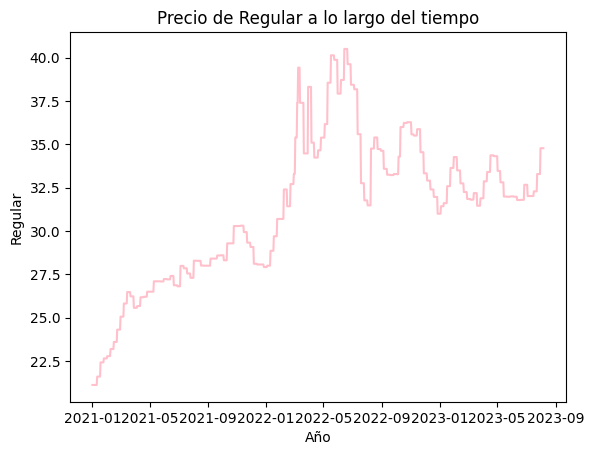

In [158]:
plt.plot(precios['Regular'], color = 'pink')
plt.gca().set(title="Precio de Regular a lo largo del tiempo", xlabel="Año", ylabel="Regular")
plt.show()


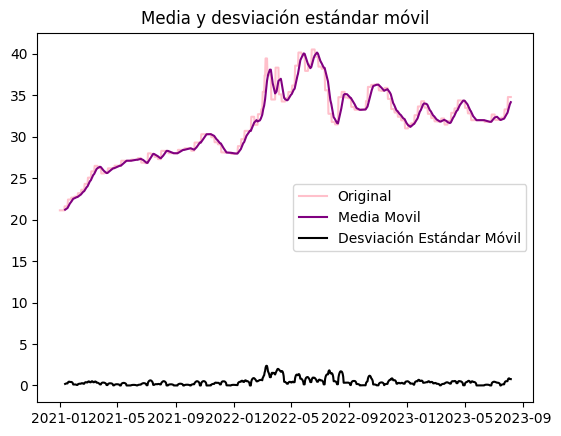

In [159]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = precios['Regular'].rolling(window=12).mean()
deMovil = precios['Regular'].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(precios['Regular'], color="pink", label="Original")
media = plt.plot(mediaMovil, color='purple', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)


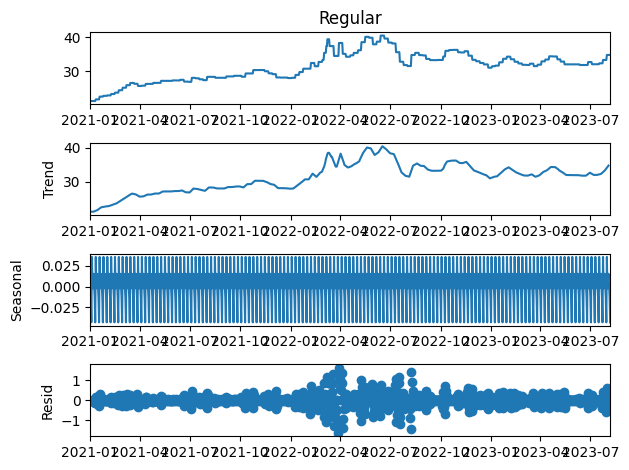

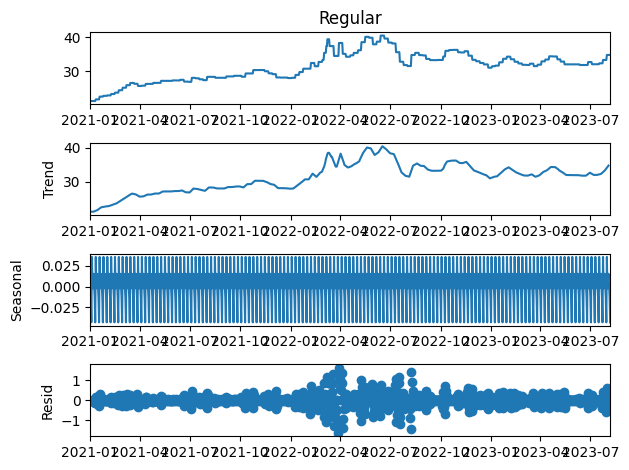

In [160]:
descomposicion = seasonal_decompose(precios['Regular'])
descomposicion.plot()

In [161]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(precios['Regular'], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -2.216026
p-value                        0.200480
# de retardos usados          18.000000
# de observaciones usadas    929.000000
Critical Value (1%)           -3.437409
Critical Value (5%)           -2.864656
Critical Value (10%)          -2.568429
dtype: float64


In [162]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
precioreg = precios['Regular'].diff()
precioreg.fillna(0,inplace=True)
dfTest = adfuller(precioreg)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)


Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.603888e+00
p-value                      2.349974e-11
# de retardos usados         1.700000e+01
# de observaciones usadas    9.300000e+02
Critical Value (1%)         -3.437401e+00
Critical Value (5%)         -2.864653e+00
Critical Value (10%)        -2.568427e+00
dtype: float64


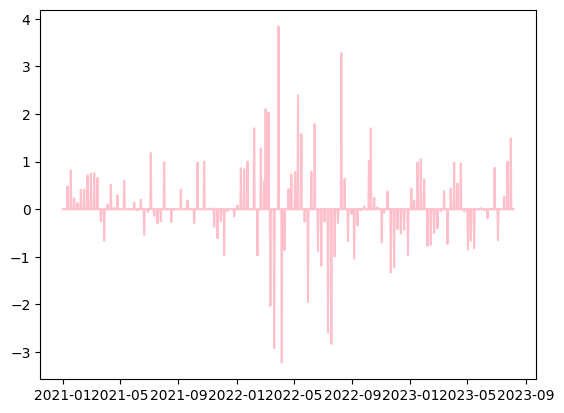

In [163]:
plt.plot(precioreg, color="pink")

In [164]:
# Convertir 'imporegular' en un array 2D utilizando reshape(-1, 1)
precioreg2d = np.array(precioreg).reshape(-1, 1)


scaler = StandardScaler()
precioregescal = scaler.fit_transform(precioreg2d) 
precioregescal[1:7]

array([[-0.03728122],
       [-0.03728122],
       [-0.03728122],
       [-0.03728122],
       [-0.03728122],
       [-0.03728122]])

In [165]:

entrenamiento = round(0.6*len(precioescal))
val_prueba = round(0.2*len(precioescal))
test = consuregularscal[(entrenamiento+val_prueba)-1:]
validation = precioescal[(entrenamiento):entrenamiento+val_prueba+1]
train = precioescal[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)


0

In [166]:
from operator import concat

def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)


#### Modelo de predicción

In [167]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

190

In [168]:
### Creamos el modelo.   
# Vamos a utilizar solo una capa lstm  
modelo3 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo3.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo3.add(Dense(1))
modelo3.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 1)                    12        
                                                                 
 dense_10 (Dense)            (1, 1)                    2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [169]:
modelo3.compile(loss='mean_squared_error',optimizer="rmsprop")

In [170]:
epocas = 50
history= modelo3.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
) 

Epoch 1/50
569/569 [==============================] - 4s 4ms/step - loss: 1.2322 - val_loss: 0.9155
Epoch 2/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2317 - val_loss: 0.9154
Epoch 3/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2316 - val_loss: 0.9154
Epoch 4/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2315 - val_loss: 0.9154
Epoch 5/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2315 - val_loss: 0.9154
Epoch 6/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2315 - val_loss: 0.9154
Epoch 7/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2315 - val_loss: 0.9153
Epoch 8/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2315 - val_loss: 0.9153
Epoch 9/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2314 - val_loss: 0.9152
Epoch 10/50
569/569 [==============================] - 1s 2ms/step - loss: 1.2314 - val_loss: 0.9152

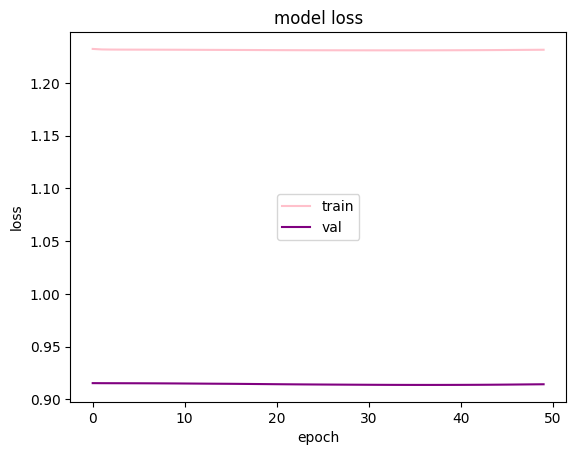

In [174]:
plt.plot(history.history['loss'], color = 'pink')
plt.plot(history.history['val_loss'], color = 'purple')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [188]:

from tqdm import tqdm

# Evaluación en los datos de entrenamiento
print("Pérdida en Entrenamiento")
loss_train = modelo3.evaluate(
    x=x_train,
    y=y_train,
    batch_size=lote,
    verbose=0  # Deshabilitar la salida detallada
)
print("Pérdida en Entrenamiento:", loss_train)

# Evaluación en los datos de validación
print("Pérdida en Validación")
loss_val = modelo3.evaluate(
    x=x_val,
    y=y_val,
    batch_size=lote,
    verbose=0  # Deshabilitar la salida detallada
)
print("Pérdida en Validación:", loss_val)

# Evaluación en los datos de prueba
print("Pérdida en Prueba")
loss_test = modelo3.evaluate(
    x=x_test,
    y=y_test,
    batch_size=lote,
    verbose=0  # Deshabilitar la salida detallada
)
print("Pérdida en Prueba:", loss_test)

Pérdida en Entrenamiento
Pérdida en Entrenamiento: 1.230718731880188
Pérdida en Validación
Pérdida en Validación: 0.9144275784492493
Pérdida en Prueba
Pérdida en Prueba: []


In [189]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo3.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo3, 1,scaler,dif=True,dif_cant=1, Series = precios['Regular'].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo3, 1,scaler,dif=True,dif_cant=1, Series = precios['Regular'].values , n=entrenamiento+val_prueba)


[]

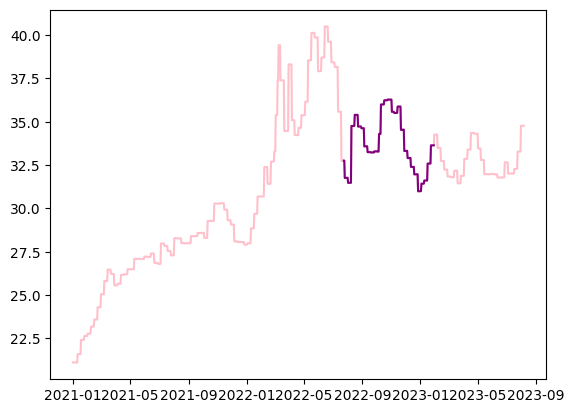

In [190]:
df_val = pd.DataFrame(prediccion_val,index=precios['Regular'][(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=precios['Regular'][entrenamiento+len(df_val):len(precios)].index)


plt.plot(precios['Regular'], color = 'pink')
plt.plot(df_val,color = 'purple' )
plt.plot(df_test, color = 'black')